# 세팅

In [1]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [76]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

# 784개의 특성에 기반한 7만개의 이미지

(70000, 784)
(70000,)


그림 저장: some_digit_plot


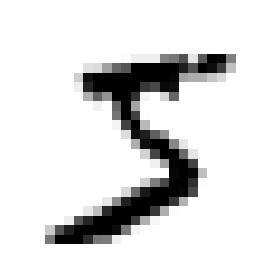

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)          # 28 x 28 픽셀이므로 형태 변경
plt.imshow(some_digit_image, cmap=mpl.cm.binary)       # 그림 그리기
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]        # 실제 레이블의 값은 5

'5'

In [7]:
y = y.astype(np.uint8)    # y 정수변환

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


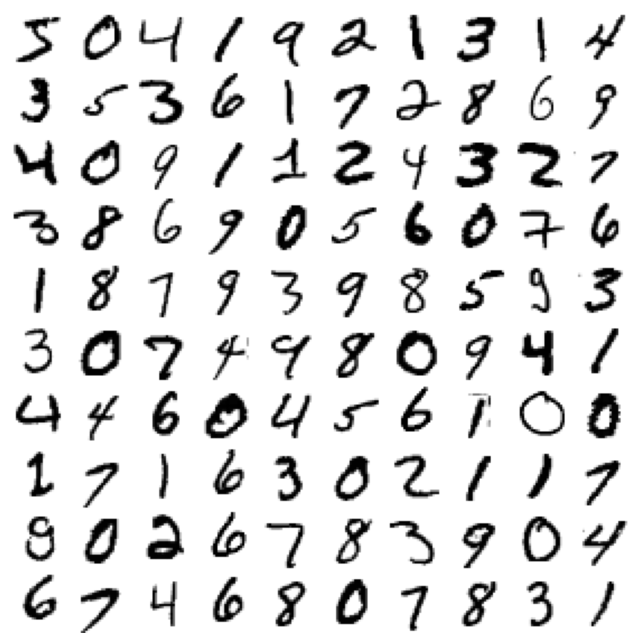

In [10]:
# 100개의 이미지 출력
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()          

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

In [12]:
# 값이 5일때만 True
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
# SGD 분류기 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])  

array([ True])

# 성능 측정

## 교차검증을 사용한 정확도 측정

In [15]:
# 사이킷런의 cross_val_score()과 거의 같은 작업을 수행하는 교차검증 구현
# StratifiedKFold는 클래스별 비율이 유지되도록 계층별 샘플링 진행
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)       # 말그대로 클론, 복사하는 것
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [16]:
# cross_val_score와 비교
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# 더미분류기 생성(모든 이미지를 '5 아님'으로 분류)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

모든 값을 '5 아님'으로 분류했는데도 불구하고 정확도가 높게 나옴
-> accuracy를 선호하지 않는 이유

## 오차행렬

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)     # 행은 실제값, 열은 예측값

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## 정밀도와 재현율

In [21]:
# 정밀도 = tp / (tp + fp), 양성 예측의 정확도
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
# 재현율 = tp / (tp + fn), 실제 양성클래스 중 양성 예측 비율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [23]:
# f1-score = 2*(precision * recall)/(precision + recall)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 정밀도/재현율 트레이드오프

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# threshold(임계값) : 양성클래스, 음성클래스로 구분하는 기준점
# 임계값이 커질수록 재현율은 낮아지고, 민감도는 올라감 / 낮아지면 반대
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 800
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


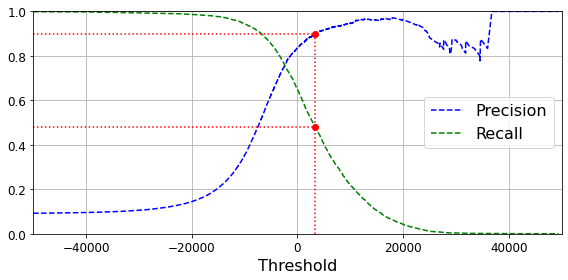

In [29]:
# precision과 recall

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                               
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                            
save_fig("precision_recall_vs_threshold_plot")                                             
plt.show()

그림 저장: precision_vs_recall_plot


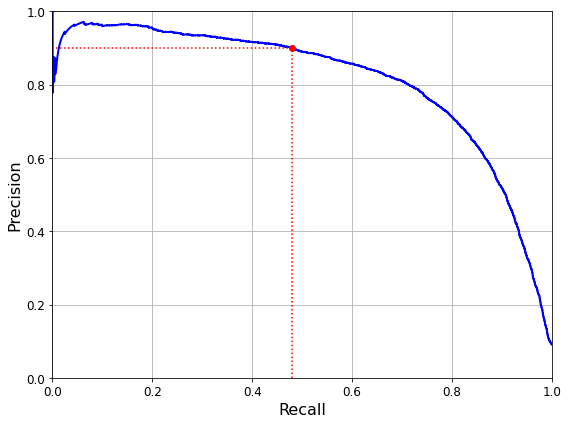

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC 곡선

In [35]:
# x : 1-특이도, y : 재현율로 그린 그래프
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


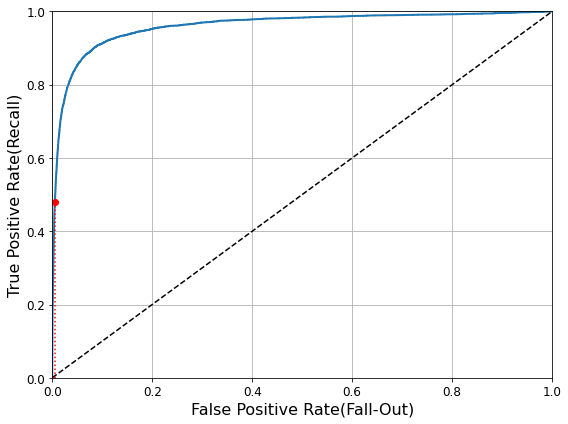

In [36]:
# tpr에 대한 fpr 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate(Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate(Recall)', fontsize=16)
    plt.grid(True)
    
plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
save_fig('roc_curve_plot')
plt.show()            

In [37]:
# AUC(ROC곡선 아래의 면적) 측정(완벽한 분류기는 1, 완전랜덤은 0.5가 나옴)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
# SGDClassifier과 RandomForestClassifier의 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')  
# predict_proba : 샘플이 행, 클래스가 열일때 샘플이 주어진 클래스에 속할 확률 배열 반환

In [39]:
y_scores_forest = y_probas_forest[:, 1]       # 양성 클래스에 대한 확률을 점수로 활용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparision_plot


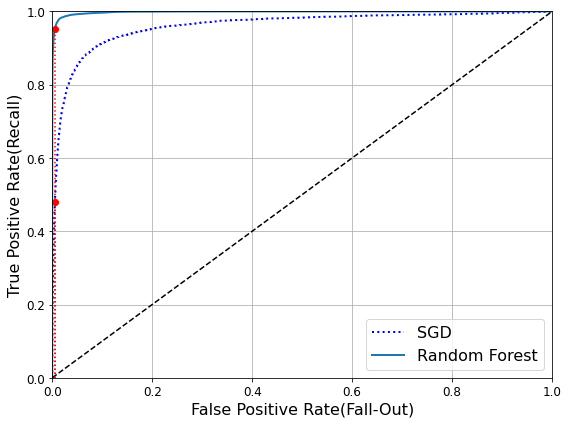

In [40]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], 'r:')
plt.plot([fpr_90], [recall_for_forest], 'ro')
plt.grid(True)
plt.legend(loc= 'lower right', fontsize=16)
save_fig('roc_curve_comparision_plot')
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)     # RF가 훨씬 높음

0.9983436731328145

In [42]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)          # RF의 정밀도

0.9905083315756169

In [43]:
recall_score(y_train_5, y_train_pred_forest)       # RF의 재현율

0.8662608374838591

# 다중분류

In [44]:
# 둘 이상의 클래스를 분류
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [46]:
np.argmax(some_digit_scores)       # 가장 높은 점수의 class 인덱스

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
svm_clf.classes_[5]

5

In [49]:
# 사이킷런에선 알고리즘에 따라 자동으로 OvR 또는 OvO를 선택함
# 이를 OvR이나 OvO로 강제선택해서 진행할 수 있음
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))      # SVC 기반으로 OvR 강제
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)  # OvR은 class의 개수만큼 분류모델 생성

10

In [51]:
# SGD는 직접 샘플을 다중분류할 수 있기 때문에 OvR이나 OvO의 적용이 필요하지 않음
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [77]:
## SGD의 정확도 평가(실행 시간때문에 실행하진 않았음)
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [78]:
## 입력값의 스케일을 조절해서 간단하게 정확도 향상(실행 시간때문에 실행하진 않음)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

# 에러분석

In [53]:
# 오차행렬
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

그림 저장: confusion_matrix_plot


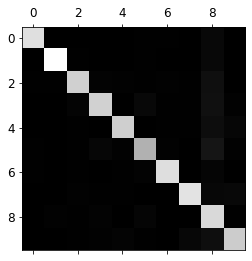

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig('confusion_matrix_plot', tight_layout=False)
plt.show()

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


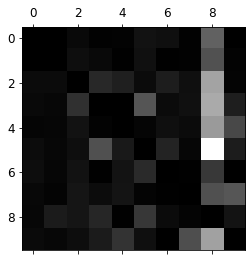

In [56]:
np.fill_diagonal(norm_conf_mx, 0)  # 대각원소만 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig('confusion_matrix_errors_plot', tight_layout=False)
plt.show()          # 많은 이미지가 8로 잘못 분류되었다는 것을 알 수 있지만, 실제 8은 적절히 8로 분류됨
                    # + 3과 5를 많이 혼동하는 패턴이 나타남

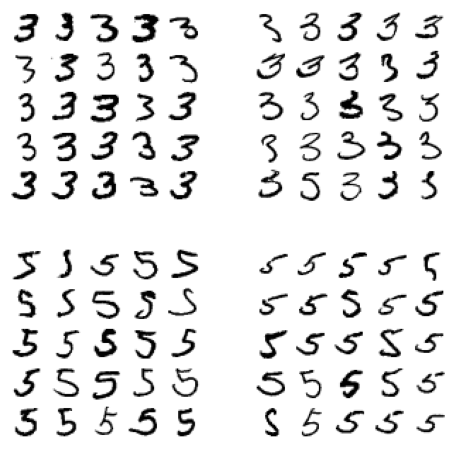

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]       # 실제값과 예측값이 모두 3인 훈련셋 X
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 왼쪽의 블록은 3으로 분류된 이미지, 오른쪽은 5로 분류된 이미지
# SGDClassifier는 픽셀에 가중치를 할당해 선형합을 하기 때문에 모델이 쉽게 혼동하게 됨

# 다중 레이블 분류

In [58]:
# 다중으로 여러 레이블을 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
## 모든 레이블에 대한 f1 score의 평균(실행 시간때문에 실행하진 않음)
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average='macro')

# 다중 출력 분류

In [61]:
# 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


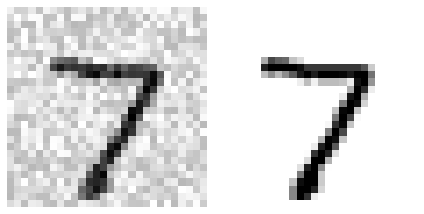

In [62]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])       # 노이즈 섞인 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index])       # 원본 이미지
save_fig('noisy_digit_example_plot')
plt.show()

그림 저장: cleaned_digit_example_plot


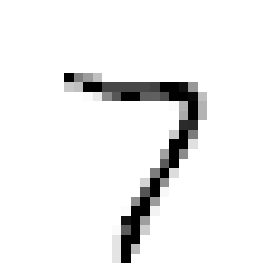

In [63]:
# 분류기를 활용해서 노이즈 섞인 이미지를 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)                   
save_fig('cleaned_digit_example_plot')          

# 더미 분류기

In [64]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

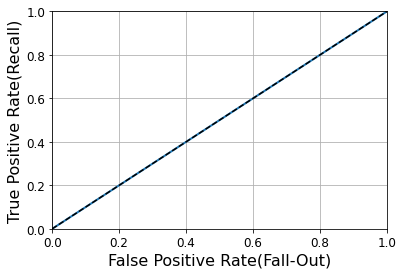

In [65]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# KNN 분류기

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [67]:
y_knn_pred = knn_clf.predict(X_test)

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

C:\Users\ytnal\AppData\Local\Temp/ipykernel_26000/3518175631.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


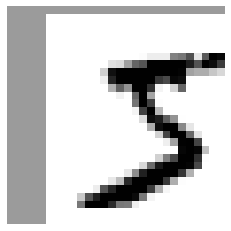

In [69]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [70]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [71]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [72]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [73]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [74]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

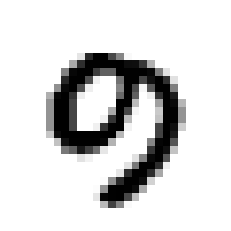

In [75]:
plot_digit(ambiguous_digit)